In [352]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import tqdm
import math
import json

import itertools

import datetime

from matplotlib import pyplot as plt

from sklearn.metrics import hamming_loss, jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
#!pip install transformers

In [4]:
from transformers import BertTokenizer, BertModel

# Data

In [5]:
train_data = json.load(open('/content/drive/MyDrive/Colab Notebooks/mtg_train_data.json'))
test_data = json.load(open('/content/drive/MyDrive/Colab Notebooks/mtg_test_data.json'))

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
print(train_data[0].keys())

dict_keys(['colors', 'convertedManaCost', 'name', 'subtypes', 'supertypes', 'text', 'type', 'types', 'power', 'toughness'])


In [8]:
max_length = 0
longest_text = ''
longest_encoding = None
for card_data in train_data + test_data:
  encoding = tokenizer.encode(card_data['text'])
  length = len(encoding)
  if length > max_length:
    max_length = length
    longest_text = card_data['text']
    longest_encoding = encoding
print('Max length:', max_length)
print('Text:', longest_text)
print('Encoding:', longest_encoding)

Max length: 146
Text: CARDNAME's power and toughness are each equal to your life total minus the life total of an opponent with the most life.
Suspend X—{X}{B}{B}{B}. X can't be 0. (Rather than cast this card from your hand, you may pay {X}{B}{B}{B} and exile it with X time counters on it. At the beginning of your upkeep, remove a time counter. When the last is removed, cast it without paying its mana cost. It has haste.)
Whenever a time counter is removed from CARDNAME while it's exiled, target player loses 1 life and you gain 1 life.
Encoding: [101, 4003, 18442, 1005, 1055, 2373, 1998, 7823, 2791, 2024, 2169, 5020, 2000, 2115, 2166, 2561, 15718, 1996, 2166, 2561, 1997, 2019, 7116, 2007, 1996, 2087, 2166, 1012, 28324, 1060, 1517, 1063, 1060, 1065, 1063, 1038, 1065, 1063, 1038, 1065, 1063, 1038, 1065, 1012, 1060, 2064, 1005, 1056, 2022, 1014, 1012, 1006, 2738, 2084, 3459, 2023, 4003, 2013, 2115, 2192, 1010, 2017, 2089, 3477, 1063, 1060, 1065, 1063, 1038, 1065, 1063, 1038, 1065, 1063, 1

In [9]:
def one_hot_encode(mapping, values):
  encoding = torch.zeros(len(mapping))
  for value in values:
    if value in mapping.keys():
      encoding[mapping[value]] = 1.0
  return encoding

def create_mapping(values):
  return {val: i for i, val in enumerate(sorted(values))}

In [10]:
example_mapping = create_mapping(['Goblin', 'Elf', 'Warrior', 'Soldier', 'Rogue'])
example_one_hot_encoding = one_hot_encode(example_mapping, ['Goblin', 'Rogue', 'Fighter'])
print(example_mapping, example_one_hot_encoding)

{'Elf': 0, 'Goblin': 1, 'Rogue': 2, 'Soldier': 3, 'Warrior': 4} tensor([0., 1., 1., 0., 0.])


In [231]:
all_types = set()
all_subtypes = {}
all_supertypes = set()

for card_data in train_data:
  all_types.update(card_data['types'])
  all_supertypes.update(card_data['supertypes'])

  for subtype in card_data['subtypes']:
    if subtype not in all_subtypes.keys():
      all_subtypes[subtype] = 1
    else:
      all_subtypes[subtype] += 1

In [232]:
print('Total types:', len(all_types))
print('Total subtypes:', len(all_subtypes))
print('Total supertypes:', len(all_supertypes))

print('Types:', all_types)
print('Supertypes:', all_supertypes)

all_subtypes_min_10 = [subtype[0] for subtype in all_subtypes.items() if subtype[1] >= 10]
print('Subtypes (min 10 count):', all_subtypes_min_10)
print('Total subtypes (min 10 count):', len(all_subtypes_min_10))

Total types: 7
Total subtypes: 265
Total supertypes: 2
Types: {'Artifact', 'Tribal', 'Sorcery', 'Enchantment', 'Planeswalker', 'Creature', 'Instant'}
Supertypes: {'Snow', 'Legendary'}
Subtypes (min 10 count): ['Zombie', 'Griffin', 'Human', 'Monk', 'Demon', 'Thrull', 'Cleric', 'Cat', 'Aura', 'Eldrazi', 'Horror', 'Specter', 'Soldier', 'Warrior', 'Bird', 'Drake', 'Wizard', 'Knight', 'Construct', 'Equipment', 'Spirit', 'Spider', 'Dragon', 'Ooze', 'Vampire', 'Lizard', 'Beast', 'Angel', 'Illusion', 'Goblin', 'Pirate', 'Elf', 'Shaman', 'Avatar', 'Dwarf', 'Hound', 'Archer', 'Homunculus', 'Mutant', 'Artificer', 'Wall', 'Vedalken', 'Rogue', 'Aetherborn', 'Shapeshifter', 'Elemental', 'Vehicle', 'Leviathan', 'Ally', 'Advisor', 'Minotaur', 'Scout', 'Kor', 'Berserker', 'Giant', 'Phoenix', 'Horse', 'Faerie', 'Crocodile', 'Sphinx', 'Myr', 'Bear', 'Golem', 'Treefolk', 'Orc', 'Snake', 'Dinosaur', 'Fish', 'Crab', 'Incarnation', 'Scarecrow', 'Hydra', 'Kithkin', 'Merfolk', 'Samurai', 'Insect', 'Naga', 'Boa

In [13]:
type_mapping = create_mapping(all_types)
subtype_mapping = create_mapping(all_subtypes_min_10)
supertype_mapping = create_mapping(all_supertypes)
print(type_mapping, supertype_mapping)

{'Artifact': 0, 'Creature': 1, 'Enchantment': 2, 'Instant': 3, 'Planeswalker': 4, 'Sorcery': 5, 'Tribal': 6} {'Legendary': 0, 'Snow': 1}


In [14]:
class MTGDataset(Dataset):

  def __init__(self, raw_card_data, include_raw_data=False):
    self.raw_card_data = raw_card_data

    self.X_text = None
    self.X_data = None
    self.Y      = None
    self.masks  = None
    
    self.__parse_cards()
    self.include_raw_data = include_raw_data
  
  def __parse_cards(self):
    for card in self.raw_card_data:
      # Include card['name'] potentially for LSTM later
      power_toughness_cost = [card['convertedManaCost'], card['power'], card['toughness']]  # indices 0, 1, 2
      type_encoded = one_hot_encode(type_mapping, card['types'])                            # indices 3-9
      supertype_encoded = one_hot_encode(supertype_mapping, card['supertypes'])             # indices 10, 11
      subtype_encoded = one_hot_encode(subtype_mapping, card['subtypes'])                   # indices 12-135

      cf = lambda c: 1.0 if c in card['colors'] else 0.0 # color function
      color_encoded = [cf('W'), cf('U'), cf('B'), cf('R'), cf('G')]

      text_encoded = tokenizer.encode_plus(
          card_data['text'],
          add_special_tokens = True,
          max_length=146,  
          padding='max_length',
          return_attention_mask = True,
          return_tensors = 'pt'
      )

      text_tensor     = text_encoded['input_ids'] # dim (1, 146)
      attention_mask  = text_encoded['attention_mask']

      power_toughness_cost_encoded = torch.tensor(power_toughness_cost)

      data_tensor  = torch.hstack([power_toughness_cost_encoded, type_encoded, supertype_encoded, subtype_encoded]).unsqueeze(0) # dim (1, 136)
      color_tensor = torch.tensor(color_encoded).unsqueeze(0) # dim (1, 5)
      
      if self.X_text is None:
        self.X_text = text_tensor
        self.X_data = data_tensor
        self.Y      = color_tensor
        self.masks  = attention_mask
      else:
        self.X_text = torch.cat([self.X_text, text_tensor])                                                             
        self.X_data = torch.cat([self.X_data, data_tensor])
        self.Y      = torch.cat([self.Y, color_tensor])     
        self.masks  = torch.cat([self.masks, attention_mask])                                                             

  def __len__(self):
    return len(self.raw_card_data)

  def __getitem__(self, idx):
    """
    Returns: X_text, X_data, attention_mask, Y (corresponding to the embedded text input, the rest of the card data and the color)
    """
    if self.include_raw_data:
      return self.X_text[idx], self.X_data[idx], self.masks[idx], self.Y[idx], self.raw_card_data[idx]
    return self.X_text[idx], self.X_data[idx], self.masks[idx], self.Y[idx]

In [13]:
train_dataset = MTGDataset(train_data)
test_dataset  = MTGDataset(test_data)

# Model

In [15]:
print(f'GPU available: {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU available: True


In [16]:
# Hyperparameters
BATCH_SIZE = 64

DIM_TRANSFORMER_OUT = 768
DIM_DATA = 136
DIM_OUTPUT= 5

DIM_HIDDEN = 128

LEARNING_RATE = 1e-5
TRANSFORMER_LEARNING_RATE = 1e-6

EPOCHS = 75

GRAD_CLIP = 3.0

In [17]:
class MagicColorClassifier(nn.Module):
  def __init__(self, dropout=0.0):
    super(MagicColorClassifier, self).__init__()

    self.transformer_model = BertModel.from_pretrained('bert-base-uncased')

    self.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(DIM_DATA + DIM_TRANSFORMER_OUT, DIM_HIDDEN),
        nn.ReLU(),
        nn.Linear(DIM_HIDDEN, DIM_OUTPUT),
        nn.Sigmoid()
    )

  def forward(self, X_text, X_data, attention_masks):
    transformer_out = self.transformer_model(X_text, attention_mask=attention_masks)['pooler_output']

    classifier_input = torch.cat([X_data, transformer_out], dim=1)
    output      = self.classifier(classifier_input)

    return output

In [17]:
model = MagicColorClassifier().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [25]:
loss_func = torch.nn.CrossEntropyLoss(reduction='sum')

In [27]:
optimizer = Adam([
    {"params": model.transformer_model.parameters(), "lr": TRANSFORMER_LEARNING_RATE},
    {"params": model.classifier.parameters()}
], lr=LEARNING_RATE)

In [21]:
performance_curves = {'loss_train': [], 'acc_train': [], 'loss_test': [], 'acc_test': []}

In [22]:
def save_model_and_curves():
  now = datetime.datetime.now()
  dt_string = now.strftime("%d_%m_%y-%H:%M")
  print("Saving model and curves", dt_string)
  torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/mtg_color_classifier_{dt_string}.model')
  with open(f'/content/drive/MyDrive/Colab Notebooks/mtg_performance_curves_{dt_string}.json', 'w') as outfile:
    json.dump(performance_curves, outfile)

In [ ]:
for epoch in range(EPOCHS):
  total_loss_train = 0.0
  total_loss_test  = 0.0
  total_acc_train  = 0.0
  total_acc_test   = 0.0
  
  for train_batch_text, train_batch_data, attention_masks, train_batch_label in tqdm.notebook.tqdm(train_data_loader): 
    train_batch_label = train_batch_label.to(device)
    output = model(train_batch_text.to(device), train_batch_data.to(device), attention_masks.to(device))

    loss = loss_func(output, train_batch_label)
    loss /= output.shape[0]
    total_loss_train += loss.item()
    

    acc = torch.all(torch.eq(torch.round(output), train_batch_label), dim=1)
    acc = acc.sum().item()
    total_acc_train += acc

    model.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
    optimizer.step()

  with torch.no_grad():
    for test_batch_text, test_batch_data, attention_masks, test_batch_label in tqdm.notebook.tqdm(test_data_loader):
      test_batch_label = test_batch_label.to(device)
      output = model(test_batch_text.to(device), test_batch_data.to(device), attention_masks.to(device))
      loss = loss_func(output, test_batch_label)
      total_loss_test += loss.item()

      acc = torch.all(torch.eq(torch.round(output), test_batch_label), dim=1)
      acc = acc.sum().item()
      total_acc_test += acc

  total_loss_train /= len(train_dataset)
  total_acc_train /= len(train_dataset)
  total_loss_test /= len(test_dataset)
  total_acc_test /= len(test_dataset)

  print(
      f'Epochs: {epoch + 1} | Train Loss: {total_loss_train : .4f} \
      | Train Accuracy: {total_acc_train : .4f} \
      | Val Loss: {total_loss_test : .4f} \
      | Val Accuracy: {total_acc_test : .4f}')
  
  performance_curves['loss_train'] += [total_loss_train]
  performance_curves['acc_train']  += [total_acc_train]
  performance_curves['loss_test']  += [total_loss_test]
  performance_curves['acc_test']   += [total_acc_test]

  if epoch > 0 and epoch % 25 == 0 and epoch != EPOCHS:
    save_model_and_curves()
save_model_and_curves()

In [ ]:
Best_so_far = "02_12_21-16:43" # 30, 31 train/test acc

In [63]:
final_train_dataset = MTGDataset(train_data, include_raw_data=True)
final_test_dataset = MTGDataset(test_data, include_raw_data=True)

final_train_data_loader = DataLoader(final_train_dataset, batch_size=1)
final_test_data_loader = DataLoader(final_test_dataset, batch_size=1)

# Results Compilation

In [191]:
model = MagicColorClassifier()
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/mtg_color_classifier_02_12_21-16:43.model'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [192]:
model = model.eval().to(device)

In [193]:
def color_sort(colors):
  if len(colors) < 2:
    return colors
  return sorted(colors, key=lambda c: ['W', 'U', 'B', 'R', 'G'].index(c))

In [194]:
def output_to_list(output): # output is a tensor(5)
  output = torch.round(output)
  output = output.squeeze(0).tolist()
  output = [bool(o) for o in output]
  col_list = []
  for i, c in enumerate(['W', 'U', 'B', 'R', 'G']):
    if output[i]:
      col_list += [c]
  return col_list

In [242]:
def final_output(data_loader, model):
  final_output_list = []

  total_acc = 0

  with torch.no_grad():
      for test_batch_text, test_batch_data, attention_masks, test_batch_label, raw_data in tqdm.notebook.tqdm(data_loader):
        test_batch_label = test_batch_label.to(device)
        output = model(test_batch_text.to(device), test_batch_data.to(device), attention_masks.to(device))
        #loss = loss_func(output, test_batch_label)
        #total_loss_test += loss.item()
        predicted_colors = output_to_list(output)

        acc = torch.all(torch.eq(torch.round(output).squeeze(0), test_batch_label)).item()
        correct = bool(acc)

        final_output_list += [{
          'correct': correct,
          'colors': color_sort([col[0] for col in raw_data['colors']]),
          'predicted_colors': color_sort(predicted_colors),
          'name': raw_data['name'][0],
          'convertedManaCost': raw_data['convertedManaCost'][0].item(),
          'power': raw_data['power'][0].item(),
          'toughness': raw_data['toughness'][0].item(),
          'type': raw_data['type'][0],
          'text': raw_data['text'][0],
          'types': [t[0] for t in raw_data['types']],
          'supertypes': [t[0] for t in raw_data['supertypes']],
          'subtypes': [t[0] for t in raw_data['subtypes']]
        }]
        total_acc += acc
  results_df = pd.DataFrame(final_output_list)
  results_df.set_index('name')

  return total_acc / len(data_loader), results_df

In [243]:
total_acc_train, train_results_df = final_output(final_train_data_loader, model)
total_acc_test, test_results_df   = final_output(final_test_data_loader, model)

  0%|          | 0/10724 [00:00<?, ?it/s]

  0%|          | 0/2382 [00:00<?, ?it/s]

In [244]:
print(f'Total accuracy train: {total_acc_train: .4f}')
print(f'Total accuracy test: {total_acc_test: .4f}')

Total accuracy train:  0.3237
Total accuracy test:  0.3157


In [245]:
train_results_df

,correct,colors,predicted_colors,name,convertedManaCost,power,toughness,type,text,types,supertypes,subtypes
0,False,[R],[U],Abandon Reason,3.0,0,0,Instant,Up to two target creatures each get +1/+0 and ...,[Instant],[],[]
1,False,[],[U],Abandoned Sarcophagus,3.0,0,0,Artifact,You may cast nonland cards with cycling from y...,[Artifact],[],[]
2,True,[B],[B],Abattoir Ghoul,4.0,3,2,Creature — Zombie,First strike\nWhenever a creature dealt damage...,[Creature],[],[Zombie]
3,True,[W],[W],Abbey Griffin,4.0,2,2,Creature — Griffin,"Flying, vigilance",[Creature],[],[Griffin]
4,False,[R],[W],Abbot of Keral Keep,2.0,2,1,Creature — Human Monk,Prowess (Whenever you cast a noncreature spell...,[Creature],[],"[Human, Monk]"
...,...,...,...,...,...,...,...,...,...,...,...,...
10719,False,[B],"[U, B]",Zulaport Cutthroat,2.0,1,1,Creature — Human Rogue Ally,Whenever CARDNAME or another creature you cont...,[Creature],[],"[Human, Rogue, Ally]"
10720,False,"[W, U, B]","[W, U]",Zur the Enchanter,4.0,1,4,Legendary Creature — Human Wizard,"Flying\nWhenever CARDNAME attacks, you may sea...",[Creature],[Legendary],"[Human, Wizard]"
10721,False,[U],[],Zur's Weirding,4.0,0,0,Enchantment,Players play with their hands revealed.\nIf a ...,[Enchantment],[],[]
10722,False,[R],"[B, R]",Zurgo Bellstriker,1.0,2,2,Legendary Creature — Orc Warrior,CARDNAME can't block creatures with power 2 or...,[Creature],[Legendary],"[Orc, Warrior]"


In [246]:
test_results_df

,correct,colors,predicted_colors,name,convertedManaCost,power,toughness,type,text,types,supertypes,subtypes
0,False,"[U, G]",[G],Abominable Treefolk,4.0,0,0,Snow Creature — Treefolk,Trample\nCARDNAME's power and toughness are ea...,[Creature],[Snow],[Treefolk]
1,False,"[U, B, G]",[B],Abomination of Gudul,6.0,3,4,Creature — Horror,Flying\nWhenever CARDNAME deals combat damage ...,[Creature],[],[Horror]
2,False,[W],[U],Abzan Advantage,2.0,0,0,Instant,Target player sacrifices an enchantment. Bolst...,[Instant],[],[]
3,False,"[W, B, G]",[W],Abzan Ascendancy,3.0,0,0,Enchantment,"When CARDNAME enters the battlefield, put a +1...",[Enchantment],[],[]
4,False,[G],"[R, G]",Abzan Beastmaster,3.0,2,1,Creature — Hound Shaman,"At the beginning of your upkeep, draw a card i...",[Creature],[],"[Hound, Shaman]"
...,...,...,...,...,...,...,...,...,...,...,...,...
2377,False,"[R, G]",[R],Zhur-Taa Goblin,2.0,2,2,Creature — Goblin Berserker,Riot (This creature enters the battlefield wit...,[Creature],[],"[Goblin, Berserker]"
2378,False,[G],[],Zodiac Monkey,2.0,2,1,Creature — Monkey,Forestwalk (This creature can't be blocked as ...,[Creature],[],[Monkey]
2379,False,[B],"[B, R]",Zombie Goliath,5.0,4,3,Creature — Zombie Giant,,[Creature],[],"[Zombie, Giant]"
2380,True,[B],[B],Zombie Musher,4.0,2,3,Snow Creature — Zombie,Snow landwalk (This creature can't be blocked ...,[Creature],[Snow],[Zombie]


In [248]:
train_results_df.to_pickle('/content/drive/MyDrive/Colab Notebooks/train_results_df.pkl')
test_results_df.to_pickle('/content/drive/MyDrive/Colab Notebooks/test_results_df.pkl')

# Analysis

In [249]:
train_results_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/train_results_df.pkl')
test_results_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/test_results_df.pkl')

In [250]:
color_pie = ['W', 'U', 'B', 'R', 'G']
combinations = []
for L in range(0, len(color_pie)+1):
    for subset in itertools.combinations(color_pie, L):
        combinations += [subset]
print(combinations)

[(), ('W',), ('U',), ('B',), ('R',), ('G',), ('W', 'U'), ('W', 'B'), ('W', 'R'), ('W', 'G'), ('U', 'B'), ('U', 'R'), ('U', 'G'), ('B', 'R'), ('B', 'G'), ('R', 'G'), ('W', 'U', 'B'), ('W', 'U', 'R'), ('W', 'U', 'G'), ('W', 'B', 'R'), ('W', 'B', 'G'), ('W', 'R', 'G'), ('U', 'B', 'R'), ('U', 'B', 'G'), ('U', 'R', 'G'), ('B', 'R', 'G'), ('W', 'U', 'B', 'R'), ('W', 'U', 'B', 'G'), ('W', 'U', 'R', 'G'), ('W', 'B', 'R', 'G'), ('U', 'B', 'R', 'G'), ('W', 'U', 'B', 'R', 'G')]


In [251]:
def gen_confusion_matrix(df, normalize=False):
  confusion_matrix = np.zeros((len(combinations), len(combinations)))
  for index, row in df.iterrows():
    confusion_matrix[combinations.index(tuple(row.colors)), combinations.index(tuple(row.predicted_colors))] += 1 
  if normalize:
    confusion_matrix = (confusion_matrix.T / confusion_matrix.sum(axis=1)).T
  return confusion_matrix

In [252]:
train_conf_matrix = gen_confusion_matrix(train_results_df, normalize=True)
test_conf_matrix = gen_confusion_matrix(test_results_df, normalize=True) # rows (y) is the true color, cols (x) is the predicted color

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [253]:
def col_text(color_tuple):
  if len(color_tuple) == 0:
    return 'C'
  return ''.join(color_tuple)

In [254]:
def show_conf_matrix(conf_matrix, labels, title):
  fig, ax = plt.subplots(figsize=(14, 14))
  ax.matshow(conf_matrix)

  for (i, j), z in np.ndenumerate(conf_matrix):
      ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
              bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
  ax.set_xticks(range(len(labels)))
  ax.set_xticklabels([col_text(c) for c in labels])
  ax.set_yticks(range(len(labels)))
  ax.set_yticklabels([col_text(c) for c in labels])

  ax.set_xlabel('Predicted Label')
  ax.set_ylabel('True Label')
  ax.xaxis.set_label_position('top') 

  plt.title(title)

  plt.show()

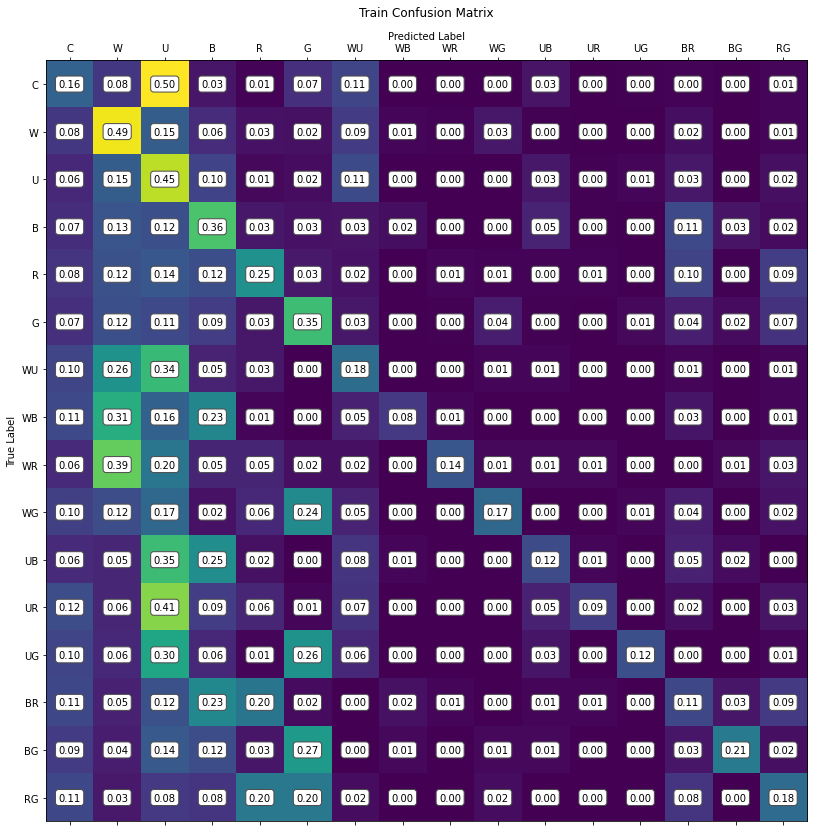

In [255]:
show_conf_matrix(train_conf_matrix[:16, :16], combinations[:16], 'Train Confusion Matrix')

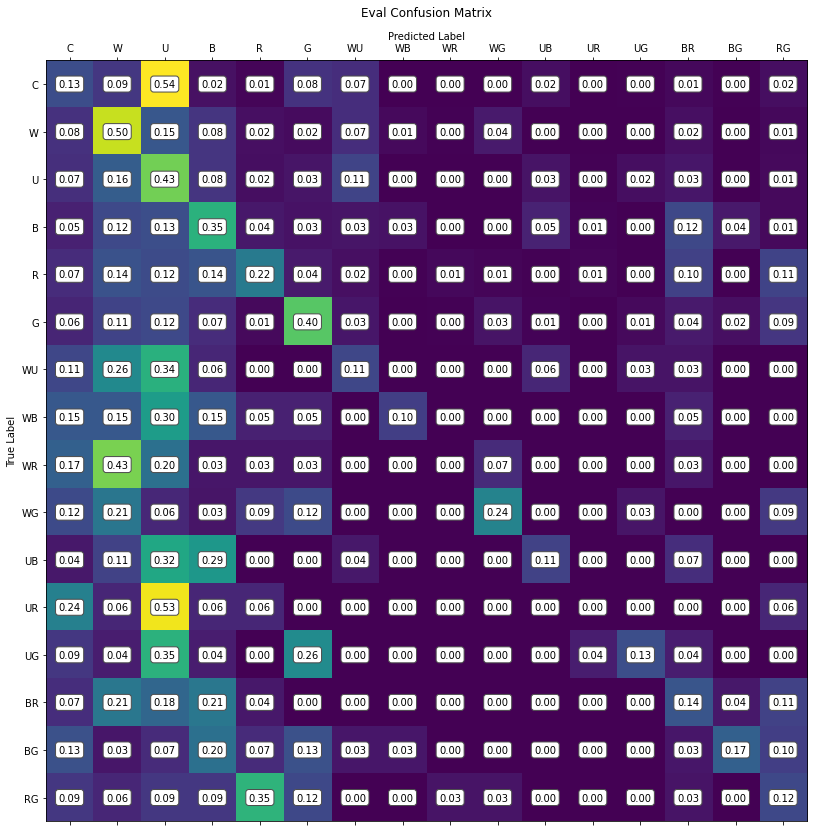

In [187]:
show_conf_matrix(test_conf_matrix[:16, :16], combinations[:16], 'Eval Confusion Matrix')

In [322]:
def accuracy_by_group(df_train, df_test, label, truncate_n=None):
  if truncate_n is not None:
    n_train, n_test = truncate_n
    #print(df.explode(label).groupby(label).filter(lambda l: truncate_n is None or len(l) > truncate_n)['correct'])
    group_count_train = df_train.explode(label).groupby(label).filter(lambda l: truncate_n is None or len(l) > n_train).groupby(label)['correct']
    group_count_test = df_test.explode(label).groupby(label).filter(lambda l: truncate_n is None or len(l) > n_test).groupby(label)['correct']
  else:
    group_count_train = df_train.explode(label).groupby(label)['correct']
    group_count_test = df_test.explode(label).groupby(label)['correct']

  return pd.DataFrame({
      "accuracy_train": group_count_train.sum() / group_count_train.count(), 
      "count_train": pd.to_numeric(group_count_train.count(), downcast='integer'), 
      "accuracy_test": group_count_test.sum() / group_count_test.count(), 
      "count_test": pd.to_numeric(group_count_test.count(), downcast='integer')
      }).dropna()

In [360]:
accuracy_by_group(train_results_df, test_results_df, 'types')

,accuracy_train,count_train,accuracy_test,count_test
types,,,,
Artifact,0.180683,1201,0.144681,235
Creature,0.431146,6049,0.420354,1356
Enchantment,0.151010,1139,0.135246,244
Instant,0.242165,1404,0.244514,319
Planeswalker,0.117241,145,0.100000,40
Sorcery,0.177548,1256,0.166090,289
Tribal,0.365854,41,0.307692,13


In [324]:
accuracy_by_group(train_results_df, test_results_df, 'supertypes')

,accuracy_train,count_train,accuracy_test,count_test
supertypes,,,,
Legendary,0.234293,764,0.228070,171
Snow,0.571429,35,0.266667,15


In [362]:
accuracy_by_group(train_results_df, test_results_df, 'subtypes', truncate_n=(100, 20))

,accuracy_train,count_train,accuracy_test,count_test
Angel,0.754902,102.0,0.680000,25.0
Aura,0.137931,493.0,0.079545,88.0
Beast,0.418079,177.0,0.321429,56.0
Cat,0.362832,113.0,0.250000,24.0
Cleric,0.625000,200.0,0.600000,50.0
Dragon,0.511278,133.0,0.523810,21.0
Druid,0.773585,106.0,0.772727,22.0
Elemental,0.131148,305.0,0.057143,70.0
Elf,0.733333,240.0,0.777778,63.0
Equipment,0.527778,216.0,0.513514,37.0


In [326]:
accuracy_by_group(train_results_df, test_results_df, 'convertedManaCost')

,accuracy_train,count_train,accuracy_test,count_test
convertedManaCost,,,,
0.0,0.060606,33,0.000000,8.0
1.0,0.289778,1125,0.265306,245.0
2.0,0.329695,2199,0.329502,522.0
3.0,0.323264,2549,0.334545,550.0
4.0,0.325447,2071,0.286344,454.0
5.0,0.308908,1392,0.316294,313.0
6.0,0.353374,815,0.367816,174.0
7.0,0.420118,338,0.337838,74.0
8.0,0.286885,122,0.444444,27.0


In [364]:
accuracy_by_group(train_results_df, test_results_df, 'colors')

,accuracy_train,count_train,accuracy_test,count_test
colors,,,,
B,0.291031,2230,0.281437,501
G,0.290498,2210,0.328000,500
R,0.212967,2221,0.178000,500
U,0.357143,2212,0.331313,495
W,0.393683,2248,0.385827,508


In [356]:
def hamming_loss_func(df):
  mlb = MultiLabelBinarizer(classes=['W', 'U', 'B', 'R', 'G'])
  y_true = mlb.fit_transform(df['colors'].tolist())
  y_pred = mlb.fit_transform(df['predicted_colors'].tolist())
  return hamming_loss(y_true, y_pred)

def jaccard_score_func(df):
  mlb = MultiLabelBinarizer(classes=['W', 'U', 'B', 'R', 'G'])
  y_true = mlb.fit_transform(df['colors'].tolist())
  y_pred = mlb.fit_transform(df['predicted_colors'].tolist())
  return jaccard_score(y_true, y_pred, average='weighted')

In [354]:
hamming_loss_train = hamming_loss_func(train_results_df)
hamming_loss_test = hamming_loss_func(test_results_df)
print('train hamming loss:', hamming_loss_train, 'test hamming loss:', hamming_loss_test)

train hamming loss: 0.22105557627750838 test hamming loss: 0.22367758186397985


In [357]:
jaccard_score_train = jaccard_score_func(train_results_df)
jaccard_score_test = jaccard_score_func(test_results_df)
print('train jaccard_score:', jaccard_score_train, 'test jaccard_score:', jaccard_score_test)

train jaccard_score: 0.3285351969604516 test jaccard_score: 0.3273370058174219
